In [1]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
import pandas as pd
from tqdm import tqdm

C:\Users\makerspace.im\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\makerspace.im\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\makerspace.im\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\makerspace.im\Anaconda3\lib\site-packages\tensorflow\python\framework\dty

In [2]:
from PIL import Image

def make_square(im, min_size=256, fill_color=(0, 0, 0, 0)):
    x, y = im.size
    size = max(min_size, x, y)
    new_im = Image.new('RGB', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

In [3]:
train = pd.read_csv('DataSet/training.csv')
train.head()


,ID,Air Bubbles,Inhomogenous Soap Surface,Injection Holes,Short Shot
0,1459,1,1,1,0
1,622,0,1,1,0
2,577,0,1,1,0
3,1030,1,1,1,0
4,259,1,1,1,0


In [4]:
train.sum(axis=0)

ID                           1009027
Air Bubbles                      941
Inhomogenous Soap Surface       1138
Injection Holes                  948
Short Shot                       521
dtype: int64

In [5]:
train_image = []
for i in tqdm(range(train.shape[0])):
    #fix = train['Air Bubbles'][i] + train['Inhomogenous Soap Surface'][i] + train['Injection Holes'][i] + train['Short Shot'][i]
    #if fix > 0 :
        #img = image.load_img('train_data/'+train['ID'][i].astype('str')+'.png', target_size=(372,1312,3))
        img = image.load_img('train_data/'+train['ID'][i].astype('str')+'.png', target_size=(224,224,3))
        #img = make_square(img)
        #img = img.resize((224, 224), Image.ANTIALIAS)
        img = image.img_to_array(img)
        img = img/255  
        train_image.append(img)
X = np.array(train_image)

100%|██████████████████████████████████████████████████████████████████████████████| 1338/1338 [00:27<00:00, 48.06it/s]


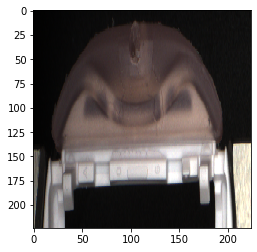

In [6]:
X.shape
plt.imshow(X[15])

In [7]:
X.shape

(1338, 224, 224, 3)

In [8]:
y = np.array(train.drop(['ID'],axis=1))
y.shape

(1338, 4)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43, test_size=0.1)

In [10]:
from keras import applications

base_model = applications.ResNet50V2(
    include_top=False,
    weights=None,
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
    classes=4)
model = Sequential()
model.add(base_model) 
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='sigmoid'))

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               51380736  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                

In [12]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['mse'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
history = model.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test), batch_size=64, verbose = 1)

'''
batch_size = 64

datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=False,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = False, # Randomly zoom image 
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=True)  # randomly flip images



#datagen.fit(X_train)  

# Set a learning rate annealer

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                              epochs = 50, validation_data = (X_test,y_test),
                              verbose = 2, steps_per_epoch= X_train.shape[0] // batch_size,
                              callbacks=None)
'''


Train on 1204 samples, validate on 134 samples
Epoch 1/25
1204/1204 [==============================] - 18s 15ms/step - loss: 5.0299 - mse: 0.3126 - val_loss: 802.9337 - val_mse: 0.3228
Epoch 2/25
1204/1204 [==============================] - 6s 5ms/step - loss: 1.3264 - mse: 0.2346 - val_loss: 169.8877 - val_mse: 0.3052
Epoch 3/25
1204/1204 [==============================] - 6s 5ms/step - loss: 1.0171 - mse: 0.2446 - val_loss: 225.8648 - val_mse: 0.3041
Epoch 4/25
1204/1204 [==============================] - 6s 5ms/step - loss: 0.6963 - mse: 0.2205 - val_loss: 12.8918 - val_mse: 0.3041
Epoch 5/25
1204/1204 [==============================] - 6s 5ms/step - loss: 0.5893 - mse: 0.1964 - val_loss: 2.1390 - val_mse: 0.2929
Epoch 6/25
1204/1204 [==============================] - 6s 5ms/step - loss: 0.5625 - mse: 0.1883 - val_loss: 0.7890 - val_mse: 0.2332
Epoch 7/25
1204/1204 [==============================] - 6s 5ms/step - loss: 0.5563 - mse: 0.1847 - val_loss: 0.6006 - val_mse: 0.2061
Epoch

'\nbatch_size = 64\n\ndatagen = ImageDataGenerator(\n            featurewise_center=False,  # set input mean to 0 over the dataset\n            samplewise_center=False,  # set each sample mean to 0\n            featurewise_std_normalization=False,  # divide inputs by std of the dataset\n            samplewise_std_normalization=False,  # divide each input by its std\n            zca_whitening=False,  # apply ZCA whitening\n            rotation_range=False,  # randomly rotate images in the range (degrees, 0 to 180)\n            zoom_range = False, # Randomly zoom image \n            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)\n            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)\n            horizontal_flip=True,  # randomly flip images\n            vertical_flip=True)  # randomly flip images\n\n\n\n#datagen.fit(X_train)  \n\n# Set a learning rate annealer\n\nhistory = model.fit_generator(datagen.flo

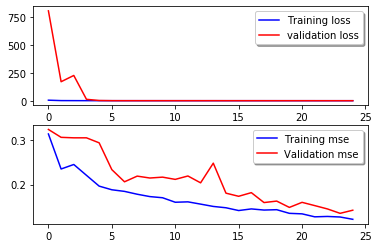

In [14]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['mse'], color='b', label="Training mse")
ax[1].plot(history.history['val_mse'], color='r',label="Validation mse")
legend = ax[1].legend(loc='best', shadow=True)

In [152]:
test = pd.read_csv('sample_submission7c60016.csv')
test.head()

,ID,Air Bubbles,Inhomogenous Soap Surface,Injection Holes,Short Shot
0,27,0,0,0,0
1,42,1,1,1,1
2,53,0,0,0,0
3,67,1,1,1,1
4,69,0,0,0,0


95
Prediction: [0.6244905  0.779017   0.890555   0.24127969]


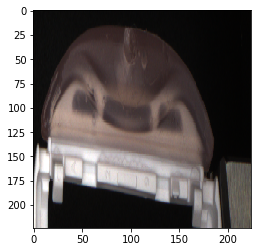

In [153]:
img = image.load_img('test_data/'+test['ID'][9].astype('str')+'.png', target_size=(224,224,3))
print(test['ID'][9])
img = image.img_to_array(img)
img = img/255
plt.imshow(img)
prob = model.predict(img.reshape(1,224,224,3))
print('Prediction:', prob[0])

In [154]:
sample = pd.read_csv('sample_submission7c60016.csv')
sample['Air Bubbles'] = sample['Air Bubbles'].astype(float)
sample['Inhomogenous Soap Surface'] = sample['Inhomogenous Soap Surface'].astype(float)
sample['Injection Holes'] = sample['Injection Holes'].astype(float)
sample['Short Shot'] = sample['Short Shot'].astype(float)

In [155]:
test_image = []

for i in tqdm(range(test.shape[0])):
    #fix = sample['Air Bubbles'][i] + sample['Inhomogenous Soap Surface'][i] + sample['Injection Holes'][i] + sample['Short Shot'][i]      
    #if fix >= 0:
        if test['ID'][i] != 327:
            #img = image.load_img('test_data/'+test['ID'][i].astype('str')+'.png', target_size=(128,512,3))
            img = image.load_img('test_data/'+sample['ID'][i].astype('str')+'.png', target_size=(224,224,3))
            #img = make_square(img)
            #img = img.resize((224, 224), Image.ANTIALIAS)
            img = image.img_to_array(img)
            img = img/255
            prob = model.predict(img.reshape(1,224,224,3))
            #prob[0] = prediction(prob[0], 0.7)
            sample["Air Bubbles"][i] = prob[0][0]
            sample["Inhomogenous Soap Surface"][i] = prob[0][1]
            sample["Injection Holes"][i] = prob[0][2]
            sample["Short Shot"][i] = prob[0][3]
            test_image.append(img)

  0%|                                                                                          | 0/150 [00:00<?, ?it/s]C:\Users\makerspace.im\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\makerspace.im\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\makerspace.im\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docu

In [156]:
print('Mean of Air Bubble:', sample['Air Bubbles'].mean())
print('Mean of Inhomogenenous Soap Surface:', sample['Inhomogenous Soap Surface'].mean())
print('Mean of Injection Holes:',sample['Injection Holes'].mean())
print('Mean of Short Shot:',sample['Short Shot'].mean())

Mean of Air Bubble: 0.693336683511734
Mean of Inhomogenenous Soap Surface: 0.8309091168642044
Mean of Injection Holes: 0.6337707241376241
Mean of Short Shot: 0.5413163445393244


In [157]:
print('Median of Air Bubble:', sample['Air Bubbles'].median())
print('Median of Inhomogenenous Soap Surface:', sample['Inhomogenous Soap Surface'].median())
print('Median of Injection Holes:',sample['Injection Holes'].median())
print('Median of Short Shot:',sample['Short Shot'].median())

Median of Air Bubble: 0.6931641697883606
Median of Inhomogenenous Soap Surface: 0.8762485384941101
Median of Injection Holes: 0.7063782513141632
Median of Short Shot: 0.5804113745689392


In [158]:
factor = 0.94
mean_first = factor*sample['Air Bubbles'].mean()
mean_second = 0.92*factor*sample['Inhomogenous Soap Surface'].mean()
mean_third = factor*sample['Injection Holes'].mean()
mean_fourth = factor*sample['Short Shot'].mean()

In [159]:
def prediction(probb, mean_first, mean_second, mean_third, mean_fourth):
    prob = probb
    for i in range(len(prob)):
        if i == 0:
            if prob[i] > mean_first:
                prob[i] = 1
            else:
                prob[i] = 0      
        if i == 1:
            if prob[i] > mean_second:
                prob[i] = 1
            else:
                prob[i] = 0   
        if i == 2:
            if prob[i] > mean_third:
                prob[i] = 1
            else:
                prob[i] = 0   
        if i == 3:
            if prob[i] > mean_fourth:
                prob[i] = 1
            else:
                prob[i] = 0
    return prob

In [160]:
for i in tqdm(range(test.shape[0])):
    
        if test['ID'][i] != 327:
            #img = image.load_img('test_data/'+test['ID'][i].astype('str')+'.png', target_size=(128,512,3))
            img = image.load_img('test_data/'+sample['ID'][i].astype('str')+'.png', target_size=(224,224,3))
            #img = make_square(img)
            #img = img.resize((224, 224), Image.ANTIALIAS)
            img = image.img_to_array(img)
            img = img/255
            prob = model.predict(img.reshape(1,224,224,3))
            prob[0] = prediction(prob[0], mean_first, mean_second, mean_third, mean_fourth)
            sample["Air Bubbles"][i] = prob[0][0]
            sample["Inhomogenous Soap Surface"][i] = prob[0][1]
            sample["Injection Holes"][i] = prob[0][2]
            sample["Short Shot"][i] = prob[0][3]
            #test_image.append(img)

  0%|                                                                                          | 0/150 [00:00<?, ?it/s]C:\Users\makerspace.im\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\makerspace.im\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\makerspace.im\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

In [161]:
sample.sum()

ID                           106077.0
Air Bubbles                      91.0
Inhomogenous Soap Surface       137.0
Injection Holes                  88.0
Short Shot                       78.0
dtype: float64

In [162]:
sample['Air Bubbles'] = sample['Air Bubbles'].astype(int)
sample['Inhomogenous Soap Surface'] = sample['Inhomogenous Soap Surface'].astype(int)
sample['Injection Holes'] = sample['Injection Holes'].astype(int)
sample['Short Shot'] = sample['Short Shot'].astype(int)

In [163]:
sample.head()


,ID,Air Bubbles,Inhomogenous Soap Surface,Injection Holes,Short Shot
0,27,1,1,1,1
1,42,1,1,1,0
2,53,1,1,1,0
3,67,0,1,0,1
4,69,0,1,1,0


In [164]:
sample.to_csv('submission_tl.csv')